In [9]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [10]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
model_path = os.path.join(parent_dir, 'models', "model_enhanced_unet_100_2.keras")

In [11]:
# Load the model
model = tf.keras.models.load_model(model_path)

In [12]:
# load test set data
X_test_path =  os.path.join(parent_dir, 'models', "X_test.npy")
X_test = np.load(X_test_path)

In [13]:
# load train set data
X_train_path =  os.path.join(parent_dir, 'models', "x_train_filtered_images.npy")
X_train = np.load(X_train_path)

In [14]:
print("Output type:", type(model.output[1]))
print("Output shape:", model.output[1].shape)

Output type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Output shape: (None, 7)


In [16]:
def crop_image_to_patches(image, crop_size):
    patches = []
    for i in range(0, image.shape[0], crop_size[0]):
        for j in range(0, image.shape[1], crop_size[1]):
            patch = image[i:i + crop_size[0], j:j + crop_size[1]]
            patches.append(patch)
    return patches

image_path = 'C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_01_missing_hole_17_3_600.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
image = cv2.resize(image, (600, 600))

patches = crop_image_to_patches(image, (100, 100))


In [17]:
patches_rgb = [np.stack((patch,)*3, axis=-1) / 255.0 for patch in patches] # stacking gryscale image *3 to make psuedo RGB image


In [18]:
def predict_fn(patches_rgb):
    patches_gray = np.mean(patches_rgb, axis=-1, keepdims=True) 
    print(patches_gray.shape)
    segmentation_predictions, classification_predictions = model.predict(patches_gray)
    print("Segmentation predictions shape:", segmentation_predictions.shape)
    print("Classification predictions shape:", classification_predictions.shape)
    
    # here the output for classification is returned. we could test on returning both ouptuts 
    return classification_predictions


In [19]:
def explain_instance_without_display(patch_rgb, predict_fn, top_labels=5, hide_color=None, num_samples=1000, num_features=5):
    # Redirect stdout to devnull to suppress output otherwise we get a large test-wall which in my opinion we do not need
    sys.stdout = open(os.devnull, 'w')
    explainer = lime_image.LimeImageExplainer()
    
    explanation = explainer.explain_instance(patch_rgb, predict_fn,
                                              top_labels=top_labels, hide_color=hide_color,
                                              num_samples=num_samples, num_features=num_features)
    # Restore stdout
    sys.stdout = sys.__stdout__
    return explanation

In [20]:
patch_explanations = []
for patch_rgb in patches_rgb:
    explanation = explain_instance_without_display(patch_rgb, predict_fn, 
                                                   top_labels=5, hide_color=0, 
                                                   num_samples=1000, num_features=5)
    patch_explanations.append(explanation)

100%|██████████| 1000/1000 [00:31<00:00, 31.78it/s]


In [21]:
# extracting masks from explanations and appending
masks = []
for explanation in patch_explanations:
    _, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                             positive_only=True,
                                             num_features=10,
                                             hide_rest=True)
    masks.append(mask)

In [22]:
# remap to the image to original size
def remap_image_from_patches(patches, image_shape):
    reconstructed_image = np.zeros(image_shape, dtype=patches[0].dtype)
    patch_size = patches[0].shape[0:2]
    k = 0
    for i in range(0, image_shape[0], patch_size[0]):
        for j in range(0, image_shape[1], patch_size[1]):
            reconstructed_image[i:i + patch_size[0], j:j + patch_size[1]] = patches[k]
            k += 1
    return reconstructed_image

In [23]:
reconstructed_image = remap_image_from_patches(patches_rgb, image_rgb.shape)
reconstructed_mask = remap_image_from_patches(masks, image_rgb.shape[:2])

overlay = mark_boundaries(reconstructed_image, reconstructed_mask)


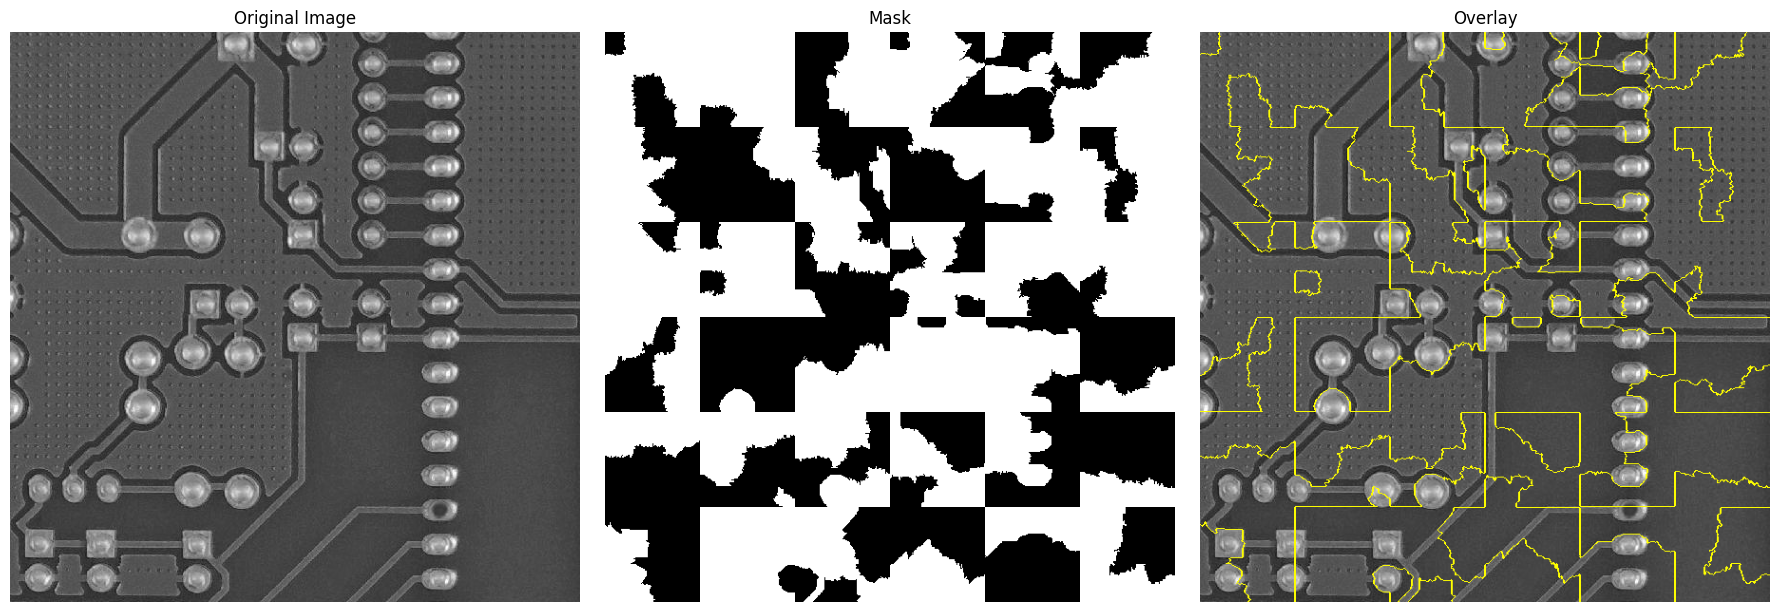

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(reconstructed_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(reconstructed_mask, cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

ax[2].imshow(overlay)
ax[2].set_title('Overlay')
ax[2].axis('off')

plt.tight_layout()
plt.show()